<a href="https://colab.research.google.com/github/BubblyOrca/CVE_WMD/blob/main/datasets/CVE%20(Common%20Vulnerabilities%20and%20Exposures)/CVE%20Excavation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CVE (Common Vulnerabilities and Exposures)
In this analysis a dataset of cyber security threats and their significance from NIST was used to detemine the relationship between product vendors, products, CVE frequency, CVE severity and more.

In [1]:
## Engineer: Jasmine Brunson aka @BubblyOrca
## Data source: https://www.kaggle.com/datasets/andrewkronser/cve-common-vulnerabilities-and-exposures?resource=download


import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Text Processing / NLP
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Modeling / Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Dimensionality Reduction (if needed for text vectorization)
from sklearn.decomposition import PCA

# utilities
import warnings
warnings.filterwarnings("ignore")
import os

In [3]:
os.getcwd()

'/content'

In [4]:
products = pd.read_csv("CVE/products.csv")
products.head()

,cve_id,vulnerable_product
0,CVE-2019-16548,google_compute_engine
1,CVE-2019-16547,google_compute_engine
2,CVE-2019-16546,google_compute_engine
3,CVE-2013-2092,dolibarr
4,CVE-2013-2091,dolibarr


In [5]:
## vendor as primary key in vendors dataset
vendors = pd.read_csv("CVE/vendors.csv")


## renaming unnamed CVE column to "cve_id"
vendors.rename(columns={"Unnamed: 0": "cve_id"}, inplace=True)

vendors.head()

,cve_id,vendor
0,CVE-2019-16548,jenkins
1,CVE-2019-16547,jenkins
2,CVE-2019-16546,jenkins
3,CVE-2013-2092,dolibarr
4,CVE-2013-2091,dolibarr


In [6]:
vendor_product = pd.read_csv("CVE/vendor_product.csv")
vendor_product.drop(vendor_product.columns[vendor_product.columns.str.contains(
    'Unnamed', case=False)], axis=1, inplace=True)
vendor_product.head()

,vendor,product
0,jenkins,google_compute_engine
1,dolibarr,dolibarr
2,mediawiki,mediawiki
3,debian,debian_linux
4,redhat,enterprise_linux


In [11]:


cve = pd.read_csv("CVE/cve.csv")
## renaming unnamed CVE column to "cve_id"

cve.rename(columns={"Unnamed: 0": "cve_id"}, inplace=True)
cve["Unnamed: 0"] = cve['cve_id'].str.strip().str.lower()
cve.head()

,cve_id,mod_date,pub_date,cvss,cwe_code,cwe_name,summary,access_authentication,access_complexity,access_vector,impact_availability,impact_confidentiality,impact_integrity,Unnamed: 0
0,CVE-2019-16548,2019-11-21 15:15:00,2019-11-21 15:15:00,6.8,352,Cross-Site Request Forgery (CSRF),A cross-site request forgery vulnerability in ...,NaN,NaN,NaN,NaN,NaN,NaN,cve-2019-16548
1,CVE-2019-16547,2019-11-21 15:15:00,2019-11-21 15:15:00,4.0,732,Incorrect Permission Assignment for Critical ...,Missing permission checks in various API endpo...,NaN,NaN,NaN,NaN,NaN,NaN,cve-2019-16547
2,CVE-2019-16546,2019-11-21 15:15:00,2019-11-21 15:15:00,4.3,639,Authorization Bypass Through User-Controlled Key,Jenkins Google Compute Engine Plugin 4.1.1 and...,NaN,NaN,NaN,NaN,NaN,NaN,cve-2019-16546
3,CVE-2013-2092,2019-11-20 21:22:00,2019-11-20 21:15:00,4.3,79,Improper Neutralization of Input During Web P...,Cross-site Scripting (XSS) in Dolibarr ERP/CRM...,NaN,NaN,NaN,NaN,NaN,NaN,cve-2013-2092
4,CVE-2013-2091,2019-11-20 20:15:00,2019-11-20 20:15:00,7.5,89,Improper Neutralization of Special Elements u...,SQL injection vulnerability in Dolibarr ERP/CR...,NaN,NaN,NaN,NaN,NaN,NaN,cve-2013-2091


In [12]:
# clean 'vendor' column of whitespace
vendors['vendor'] = vendors['vendor'].str.strip().str.lower()
vendor_product['vendor'] = vendor_product['vendor'].str.strip().str.lower()

# merge both datasets on 'vendor' as primary key
merged_df = pd.merge(vendors, vendor_product, on='vendor', how='inner')

merged_df

,cve_id,vendor,product
0,CVE-2019-16548,jenkins,google_compute_engine
1,CVE-2019-16548,jenkins,jenkins
2,CVE-2019-16548,jenkins,icescrum
3,CVE-2019-16548,jenkins,neoload
4,CVE-2019-16548,jenkins,credentials_binding
...,...,...,...
18141357,CVE-2002-1432,coxco_support,midicart_asp
18141358,CVE-2002-1432,coxco_support,midicart_asp_maxi
18141359,CVE-2002-1432,coxco_support,midicart_asp_plus
18141360,CVE-2002-1432,coxco_support,salescart-pro


product
forms_server        8835
java                7856
identity_manager    6958
download_manager    6858
director            6603
Name: cve_id, dtype: int64


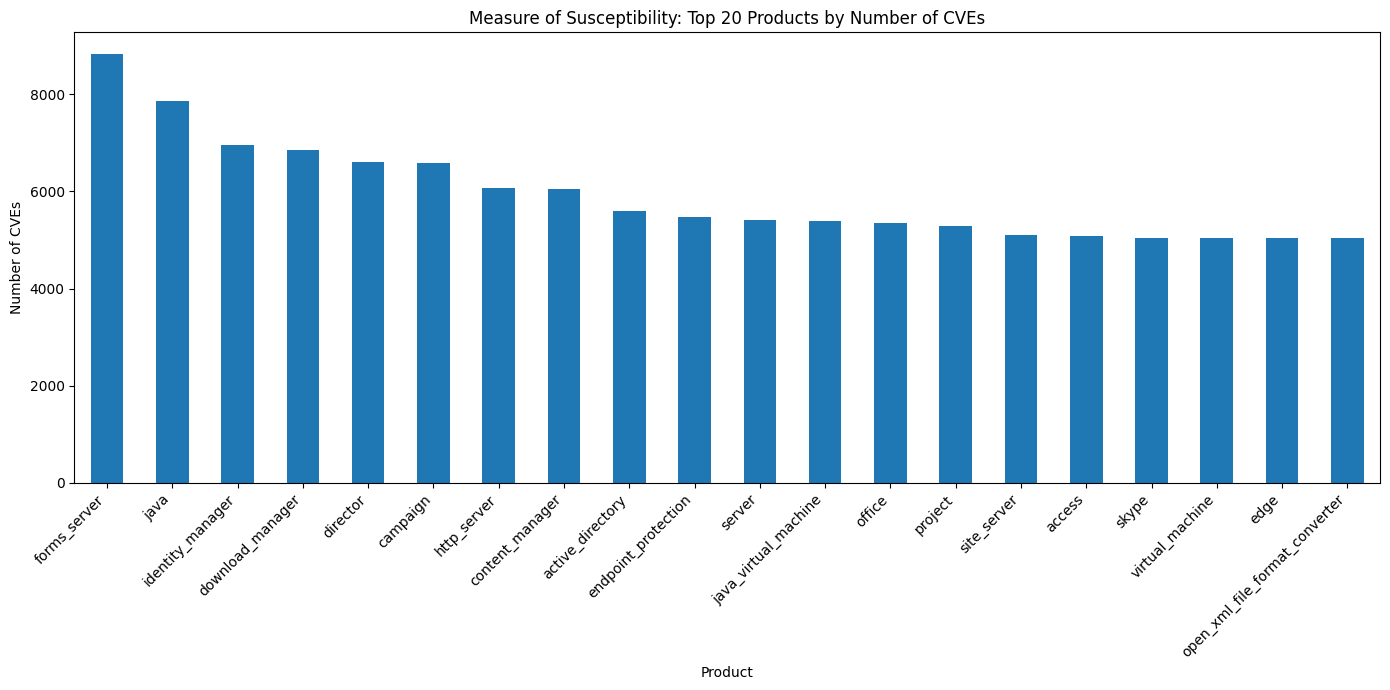

In [13]:


# Step 1: Group by 'product' and count how many CVE IDs each has
cve_counts = merged_df.groupby('product')['cve_id'].count().sort_values(ascending=False)

# Preview the top few
print(cve_counts.head())

# Step 2: Bar Chart – Top 20 products with most CVEs
plt.figure(figsize=(14, 7))
cve_counts.head(20).plot(kind='bar')
plt.title('Measure of Susceptibility: Top 20 Products by Number of CVEs')
plt.xlabel('Product')
plt.ylabel('Number of CVEs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


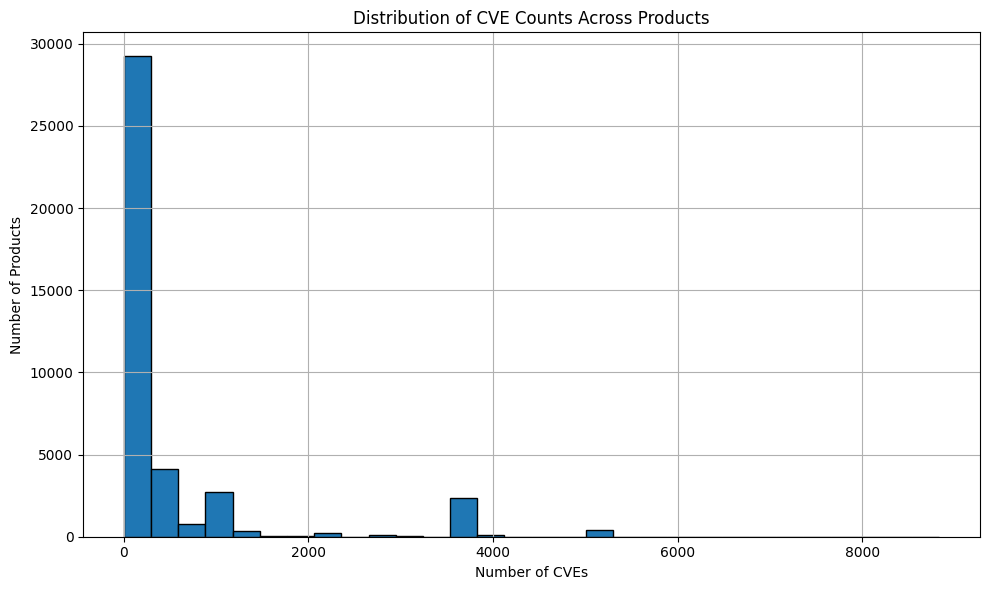

<Figure size 640x480 with 0 Axes>

In [14]:
# Histogram – Distribution of how many CVEs products have
plt.figure(figsize=(10, 6))
plt.hist(cve_counts, bins=30, edgecolor='black')
plt.title('Distribution of CVE Counts Across Products')
plt.xlabel('Number of CVEs')
plt.ylabel('Number of Products')
plt.grid(True)
plt.tight_layout()
plt.show()
plt.tight_layout()

In [15]:
# clean 'vendor' column of whitespace
#products['cve_id'] = cve['cve_id'].str.strip().str.lower()
#cve['cve_id'] = cve['cve_id'].str.strip().str.lower()

# Merge both datasets on 'vendor' as primary key
merged_df1 = pd.merge(products, cve, on='cve_id', how='inner')

merged_df1.head()

,cve_id,vulnerable_product,mod_date,pub_date,cvss,cwe_code,cwe_name,summary,access_authentication,access_complexity,access_vector,impact_availability,impact_confidentiality,impact_integrity,Unnamed: 0
0,CVE-2019-16548,google_compute_engine,2019-11-21 15:15:00,2019-11-21 15:15:00,6.8,352,Cross-Site Request Forgery (CSRF),A cross-site request forgery vulnerability in ...,NaN,NaN,NaN,NaN,NaN,NaN,cve-2019-16548
1,CVE-2019-16547,google_compute_engine,2019-11-21 15:15:00,2019-11-21 15:15:00,4.0,732,Incorrect Permission Assignment for Critical ...,Missing permission checks in various API endpo...,NaN,NaN,NaN,NaN,NaN,NaN,cve-2019-16547
2,CVE-2019-16546,google_compute_engine,2019-11-21 15:15:00,2019-11-21 15:15:00,4.3,639,Authorization Bypass Through User-Controlled Key,Jenkins Google Compute Engine Plugin 4.1.1 and...,NaN,NaN,NaN,NaN,NaN,NaN,cve-2019-16546
3,CVE-2013-2092,dolibarr,2019-11-20 21:22:00,2019-11-20 21:15:00,4.3,79,Improper Neutralization of Input During Web P...,Cross-site Scripting (XSS) in Dolibarr ERP/CRM...,NaN,NaN,NaN,NaN,NaN,NaN,cve-2013-2092
4,CVE-2013-2091,dolibarr,2019-11-20 20:15:00,2019-11-20 20:15:00,7.5,89,Improper Neutralization of Special Elements u...,SQL injection vulnerability in Dolibarr ERP/CR...,NaN,NaN,NaN,NaN,NaN,NaN,cve-2013-2091


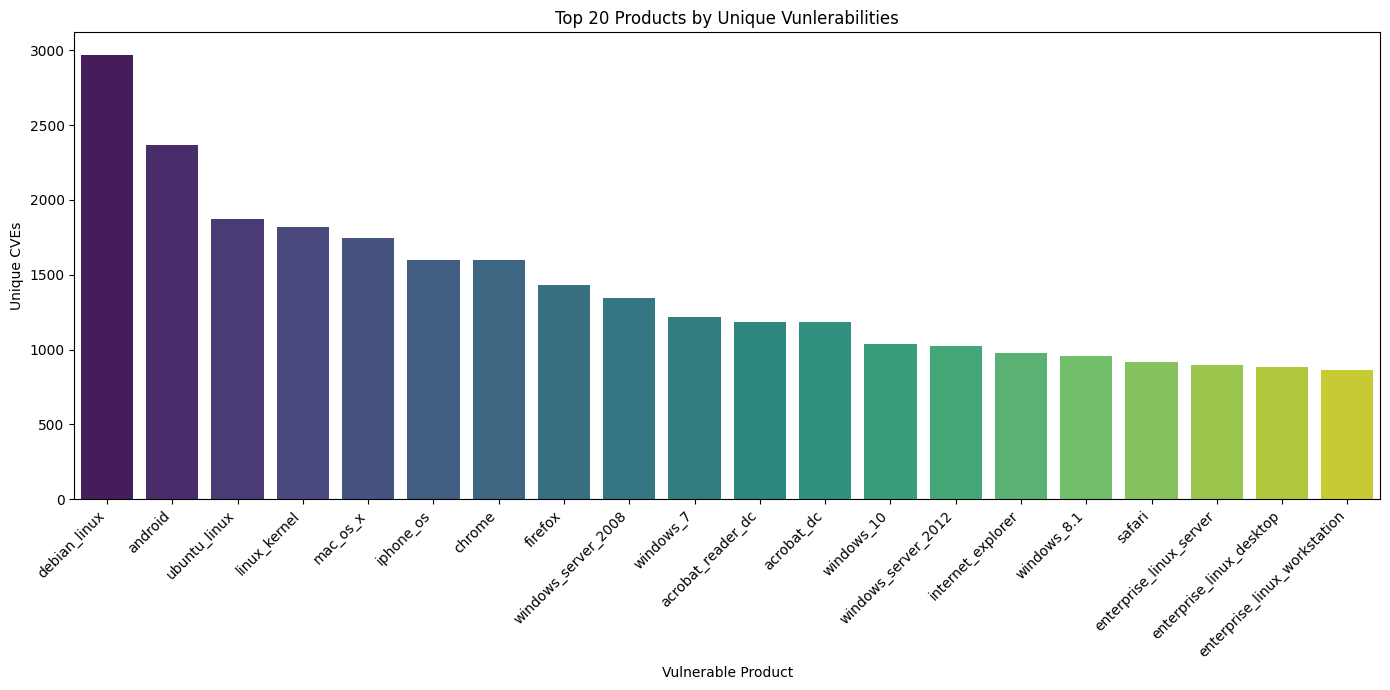

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by 'vulnerable_product' and count distinct CVEs
product_cve_counts = merged_df1.groupby('vulnerable_product')['cve_id'].nunique().sort_values(ascending=False)

# Plot top 20 products
plt.figure(figsize=(14, 7))
sns.barplot(
    x=product_cve_counts.head(20).index,
    y=product_cve_counts.head(20).values,
    palette='viridis'
)
plt.title('Top 20 Products by Unique Vunlerabilities')
plt.xlabel('Vulnerable Product')
plt.ylabel('Unique CVEs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
merged_df1.groupby('vulnerable_product')['cve_id'].nunique()

vulnerable_product
-                                          8
-5120-24g-poe\+_\(370w\)_si_switch         1
-ma5200g                                   1
.net_agent                                 1
.net_communication_protocol_components     2
                                          ..
zzcms                                     39
zziplib                                   15
zzmcms                                     1
zzzphp                                     7
zzzphp_cms                                 1
Name: cve_id, Length: 40553, dtype: int64

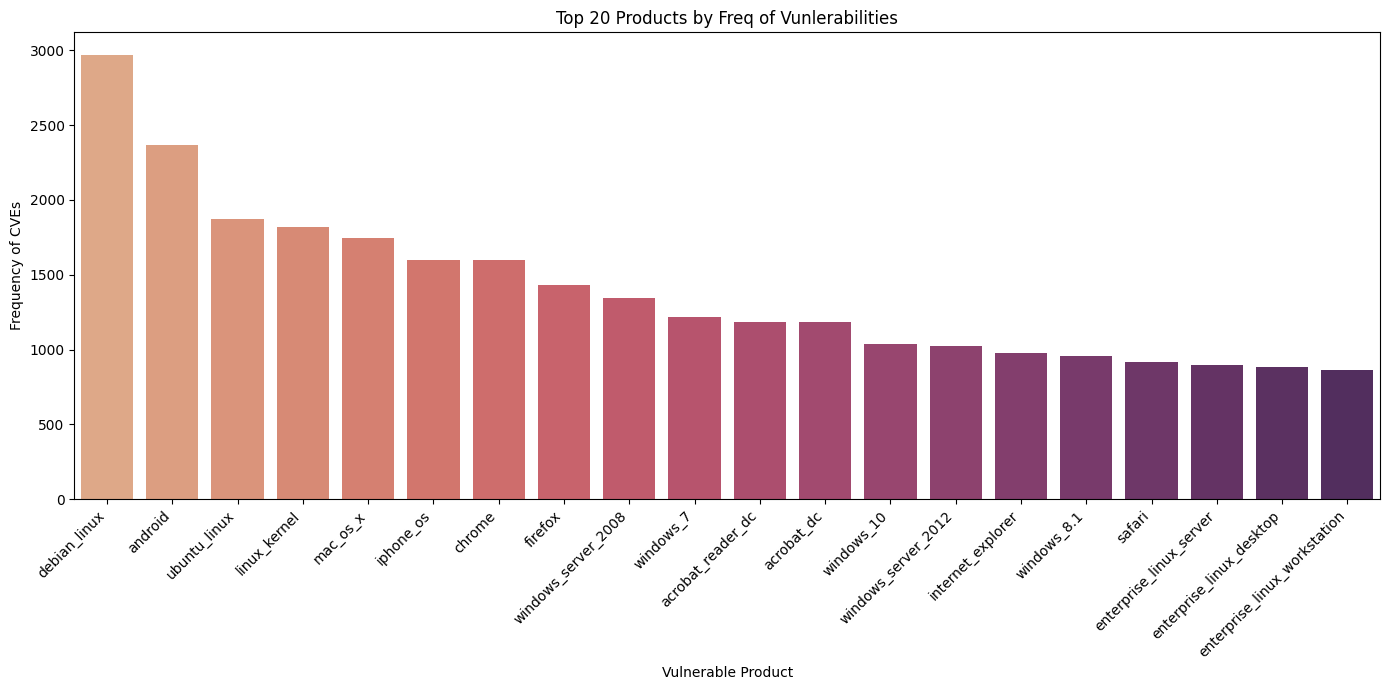

In [19]:
# group by 'vulnerable_product' and count distinct CVEs
product_cve_vcounts = merged_df1.groupby('vulnerable_product')['cve_id'].count().sort_values(ascending=False)

# plot top 20 vulnerable products
plt.figure(figsize=(14, 7))
sns.barplot(
    x=product_cve_vcounts.head(20).index,
    y=product_cve_vcounts.head(20).values,
    palette='flare'
)
plt.title('Top 20 Products by Freq of Vunlerabilities')
plt.xlabel('Vulnerable Product')
plt.ylabel('Frequency of CVEs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

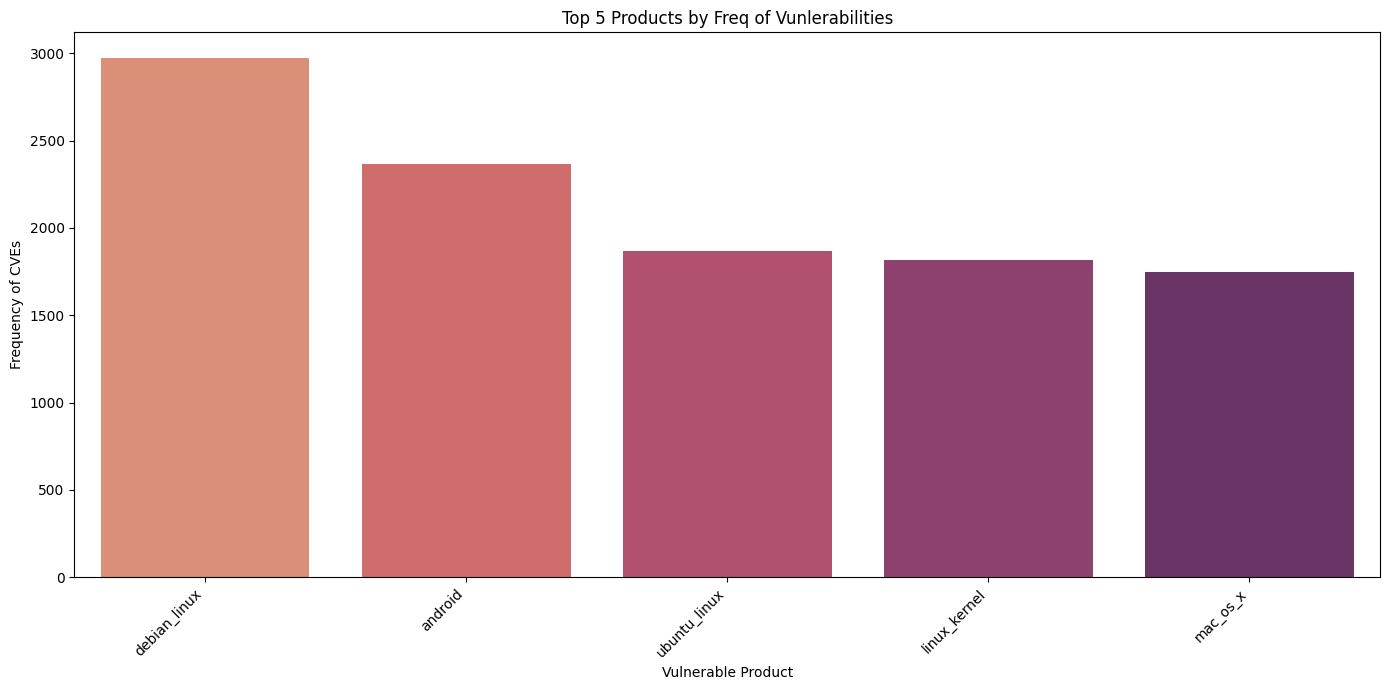

In [20]:
plt.figure(figsize=(14, 7))
sns.barplot(
    x=product_cve_vcounts.head(5).index,
    y=product_cve_vcounts.head(5).values,
    palette='flare'
)
plt.title('Top 5 Products by Freq of Vunlerabilities')
plt.xlabel('Vulnerable Product')
plt.ylabel('Frequency of CVEs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

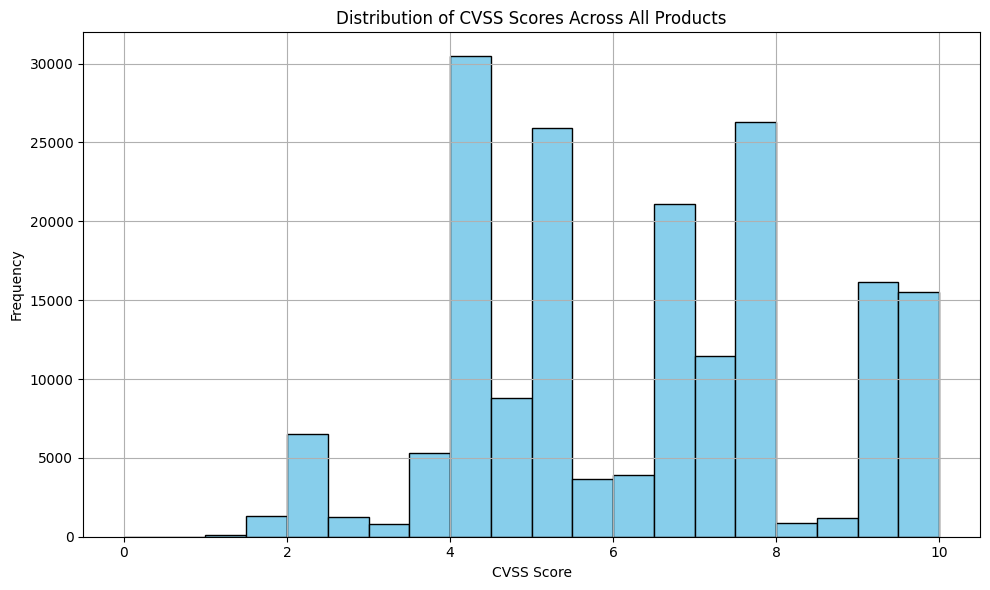

In [21]:
plt.figure(figsize=(10, 6))
plt.hist(merged_df1['cvss'].dropna(), bins=20, edgecolor='black', color='skyblue')
plt.title('Distribution of CVSS Scores Across All Products')
plt.xlabel('CVSS Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


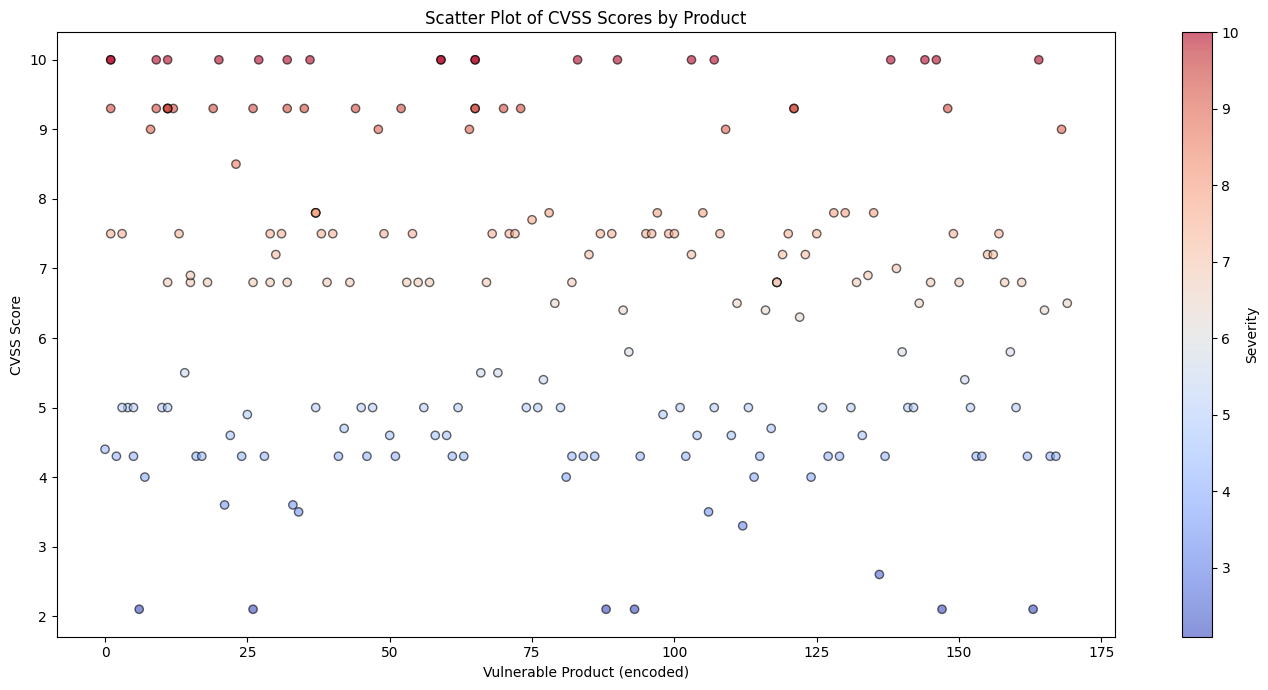

In [22]:
# take a sample for readability
sample = merged_df1[['vulnerable_product', 'cvss']].dropna().sample(n=200, random_state=42)

# encode products as numbers for x-axis
product_labels = {product: i for i, product in enumerate(sample['vulnerable_product'].unique())}
x = sample['vulnerable_product'].map(product_labels)
y = sample['cvss']

plt.figure(figsize=(14, 7))
plt.scatter(x, y, alpha=0.6, c=y, cmap='coolwarm', edgecolor='k')
plt.title('Scatter Plot of CVSS Scores by Product')
plt.xlabel('Vulnerable Product (encoded)')
plt.ylabel('CVSS Score')
plt.colorbar(label='Severity')
plt.tight_layout()
plt.show()


In [23]:
## renaming unnamed vuln product column to "product"
merged_df1.rename(columns={"vulnerable_product": "product"}, inplace=True)
merged_df1.head()

,cve_id,product,mod_date,pub_date,cvss,cwe_code,cwe_name,summary,access_authentication,access_complexity,access_vector,impact_availability,impact_confidentiality,impact_integrity,Unnamed: 0
0,CVE-2019-16548,google_compute_engine,2019-11-21 15:15:00,2019-11-21 15:15:00,6.8,352,Cross-Site Request Forgery (CSRF),A cross-site request forgery vulnerability in ...,NaN,NaN,NaN,NaN,NaN,NaN,cve-2019-16548
1,CVE-2019-16547,google_compute_engine,2019-11-21 15:15:00,2019-11-21 15:15:00,4.0,732,Incorrect Permission Assignment for Critical ...,Missing permission checks in various API endpo...,NaN,NaN,NaN,NaN,NaN,NaN,cve-2019-16547
2,CVE-2019-16546,google_compute_engine,2019-11-21 15:15:00,2019-11-21 15:15:00,4.3,639,Authorization Bypass Through User-Controlled Key,Jenkins Google Compute Engine Plugin 4.1.1 and...,NaN,NaN,NaN,NaN,NaN,NaN,cve-2019-16546
3,CVE-2013-2092,dolibarr,2019-11-20 21:22:00,2019-11-20 21:15:00,4.3,79,Improper Neutralization of Input During Web P...,Cross-site Scripting (XSS) in Dolibarr ERP/CRM...,NaN,NaN,NaN,NaN,NaN,NaN,cve-2013-2092
4,CVE-2013-2091,dolibarr,2019-11-20 20:15:00,2019-11-20 20:15:00,7.5,89,Improper Neutralization of Special Elements u...,SQL injection vulnerability in Dolibarr ERP/CR...,NaN,NaN,NaN,NaN,NaN,NaN,cve-2013-2091


In [24]:
merged_df1['product'] = merged_df1['product'].str.strip().str.lower()
vendor_product['product'] = vendor_product['product'].str.strip().str.lower()

final_df = pd.merge(merged_df1, vendor_product, on='product', how='inner')

final_df.head()

,cve_id,product,mod_date,pub_date,cvss,cwe_code,cwe_name,summary,access_authentication,access_complexity,access_vector,impact_availability,impact_confidentiality,impact_integrity,Unnamed: 0,vendor
0,CVE-2019-16548,google_compute_engine,2019-11-21 15:15:00,2019-11-21 15:15:00,6.8,352,Cross-Site Request Forgery (CSRF),A cross-site request forgery vulnerability in ...,NaN,NaN,NaN,NaN,NaN,NaN,cve-2019-16548,jenkins
1,CVE-2019-16547,google_compute_engine,2019-11-21 15:15:00,2019-11-21 15:15:00,4.0,732,Incorrect Permission Assignment for Critical ...,Missing permission checks in various API endpo...,NaN,NaN,NaN,NaN,NaN,NaN,cve-2019-16547,jenkins
2,CVE-2019-16546,google_compute_engine,2019-11-21 15:15:00,2019-11-21 15:15:00,4.3,639,Authorization Bypass Through User-Controlled Key,Jenkins Google Compute Engine Plugin 4.1.1 and...,NaN,NaN,NaN,NaN,NaN,NaN,cve-2019-16546,jenkins
3,CVE-2013-2092,dolibarr,2019-11-20 21:22:00,2019-11-20 21:15:00,4.3,79,Improper Neutralization of Input During Web P...,Cross-site Scripting (XSS) in Dolibarr ERP/CRM...,NaN,NaN,NaN,NaN,NaN,NaN,cve-2013-2092,dolibarr
4,CVE-2013-2091,dolibarr,2019-11-20 20:15:00,2019-11-20 20:15:00,7.5,89,Improper Neutralization of Special Elements u...,SQL injection vulnerability in Dolibarr ERP/CR...,NaN,NaN,NaN,NaN,NaN,NaN,cve-2013-2091,dolibarr


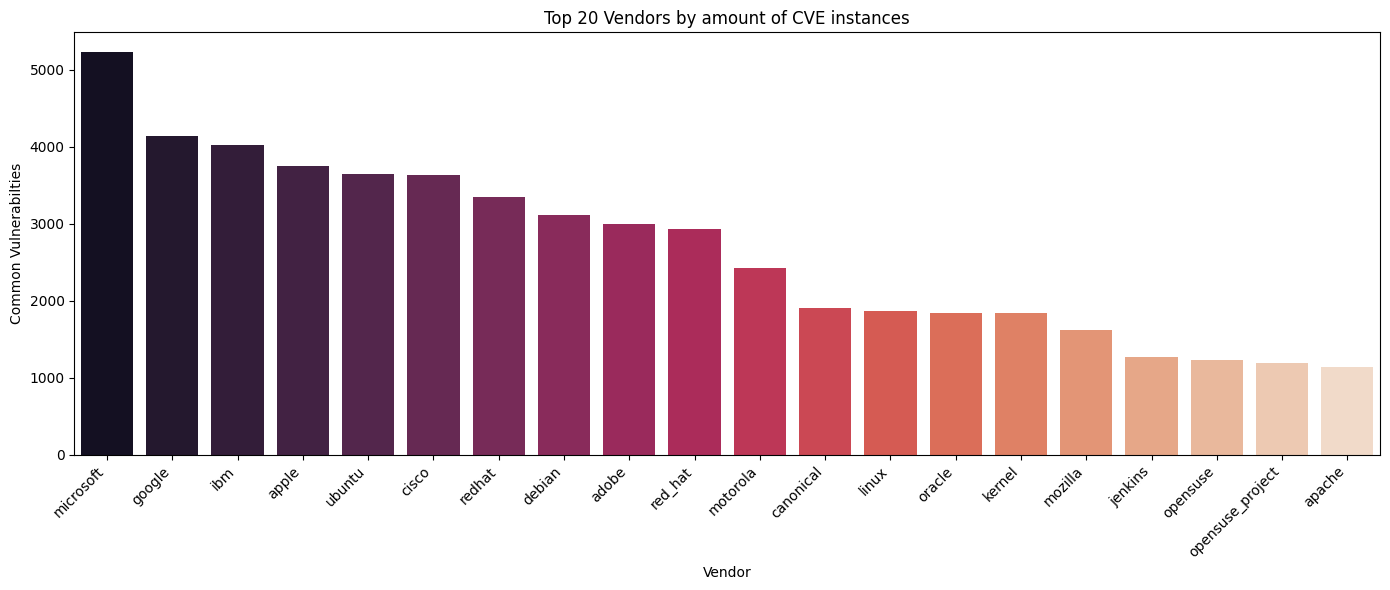

In [26]:
cve_counts_by_vendor = final_df.groupby('vendor')['cve_id'].nunique().sort_values(ascending=False)

# Plot top 15 vendors
plt.figure(figsize=(14, 6))
sns.barplot(x=cve_counts_by_vendor.head(20).index, y=cve_counts_by_vendor.head(20).values, palette='rocket')
plt.title('Top 20 Vendors by amount of CVE instances')
plt.xlabel('Vendor')
plt.ylabel('Common Vulnerabilties')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

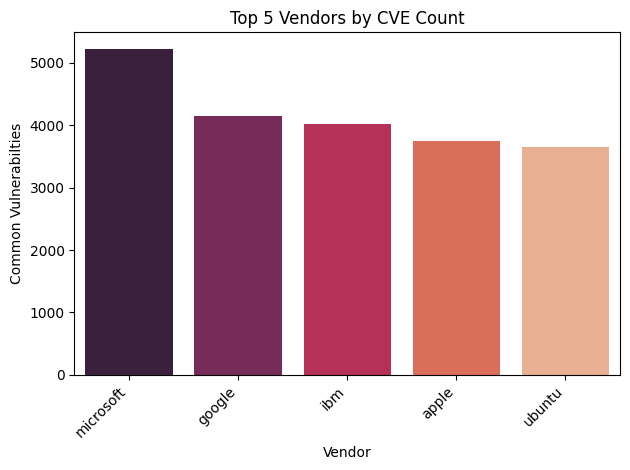

In [27]:
sns.barplot(x=cve_counts_by_vendor.head(5).index, y=cve_counts_by_vendor.head(5).values, palette='rocket')
plt.title('Top 5 Vendors by CVE Count')
plt.xlabel('Vendor')
plt.ylabel('Common Vulnerabilties')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [35]:
merged_df1 = pd.merge(merged_df1, vendors, on='cve_id', how='inner')

merged_df1.head()

,cve_id,product,mod_date,pub_date,cvss,cwe_code,cwe_name,summary,access_authentication,access_complexity,access_vector,impact_availability,impact_confidentiality,impact_integrity,Unnamed: 0,vendor
0,CVE-2019-16548,google_compute_engine,2019-11-21 15:15:00,2019-11-21 15:15:00,6.8,352,Cross-Site Request Forgery (CSRF),A cross-site request forgery vulnerability in ...,NaN,NaN,NaN,NaN,NaN,NaN,cve-2019-16548,jenkins
1,CVE-2019-16547,google_compute_engine,2019-11-21 15:15:00,2019-11-21 15:15:00,4.0,732,Incorrect Permission Assignment for Critical ...,Missing permission checks in various API endpo...,NaN,NaN,NaN,NaN,NaN,NaN,cve-2019-16547,jenkins
2,CVE-2019-16546,google_compute_engine,2019-11-21 15:15:00,2019-11-21 15:15:00,4.3,639,Authorization Bypass Through User-Controlled Key,Jenkins Google Compute Engine Plugin 4.1.1 and...,NaN,NaN,NaN,NaN,NaN,NaN,cve-2019-16546,jenkins
3,CVE-2013-2092,dolibarr,2019-11-20 21:22:00,2019-11-20 21:15:00,4.3,79,Improper Neutralization of Input During Web P...,Cross-site Scripting (XSS) in Dolibarr ERP/CRM...,NaN,NaN,NaN,NaN,NaN,NaN,cve-2013-2092,dolibarr
4,CVE-2013-2091,dolibarr,2019-11-20 20:15:00,2019-11-20 20:15:00,7.5,89,Improper Neutralization of Special Elements u...,SQL injection vulnerability in Dolibarr ERP/CR...,NaN,NaN,NaN,NaN,NaN,NaN,cve-2013-2091,dolibarr


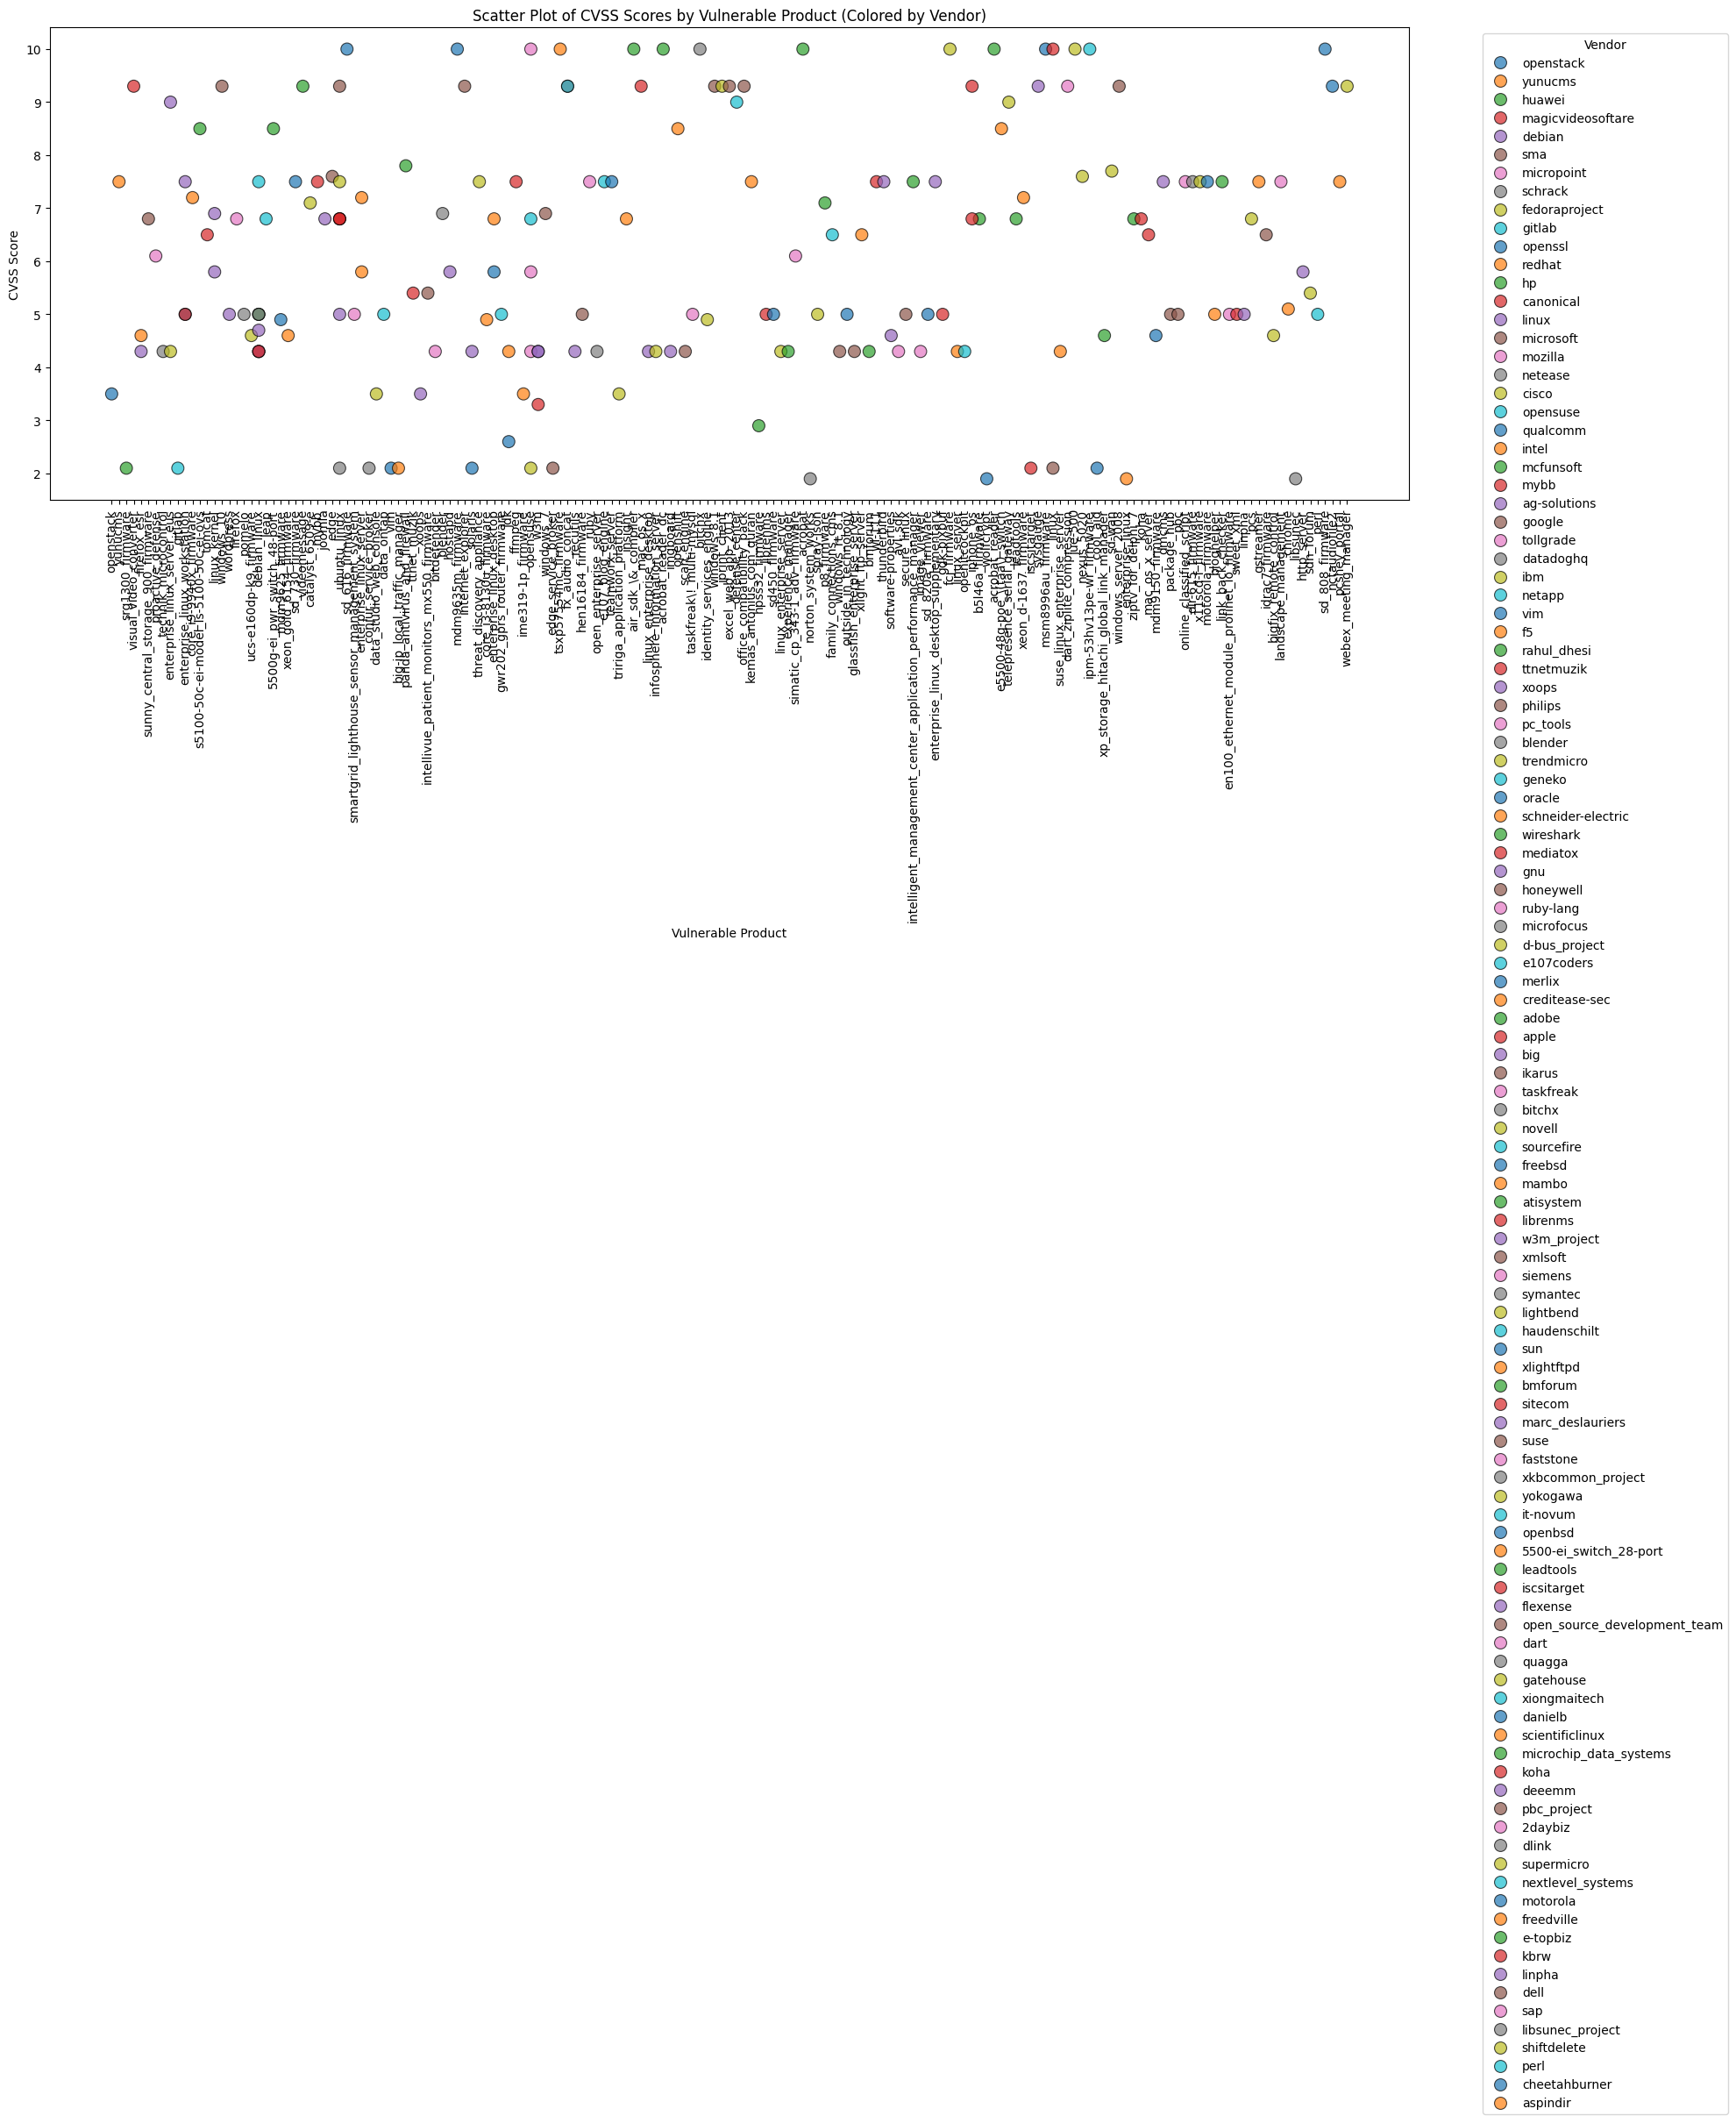

In [37]:
sample = merged_df1[['product', 'cvss', 'vendor']].dropna().sample(n=200, random_state=42)

plt.figure(figsize=(20, 7))
sns.scatterplot(
    data=sample,
    x='product',
    y='cvss',
    hue='vendor',
    palette='tab10',
    s=100,
    edgecolor='k',
    alpha=0.7
)

plt.title('Scatter Plot of CVSS Scores by Vulnerable Product (Colored by Vendor)')
plt.xlabel('Vulnerable Product')
plt.ylabel('CVSS Score')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Vendor')
plt.tight_layout()
plt.show()


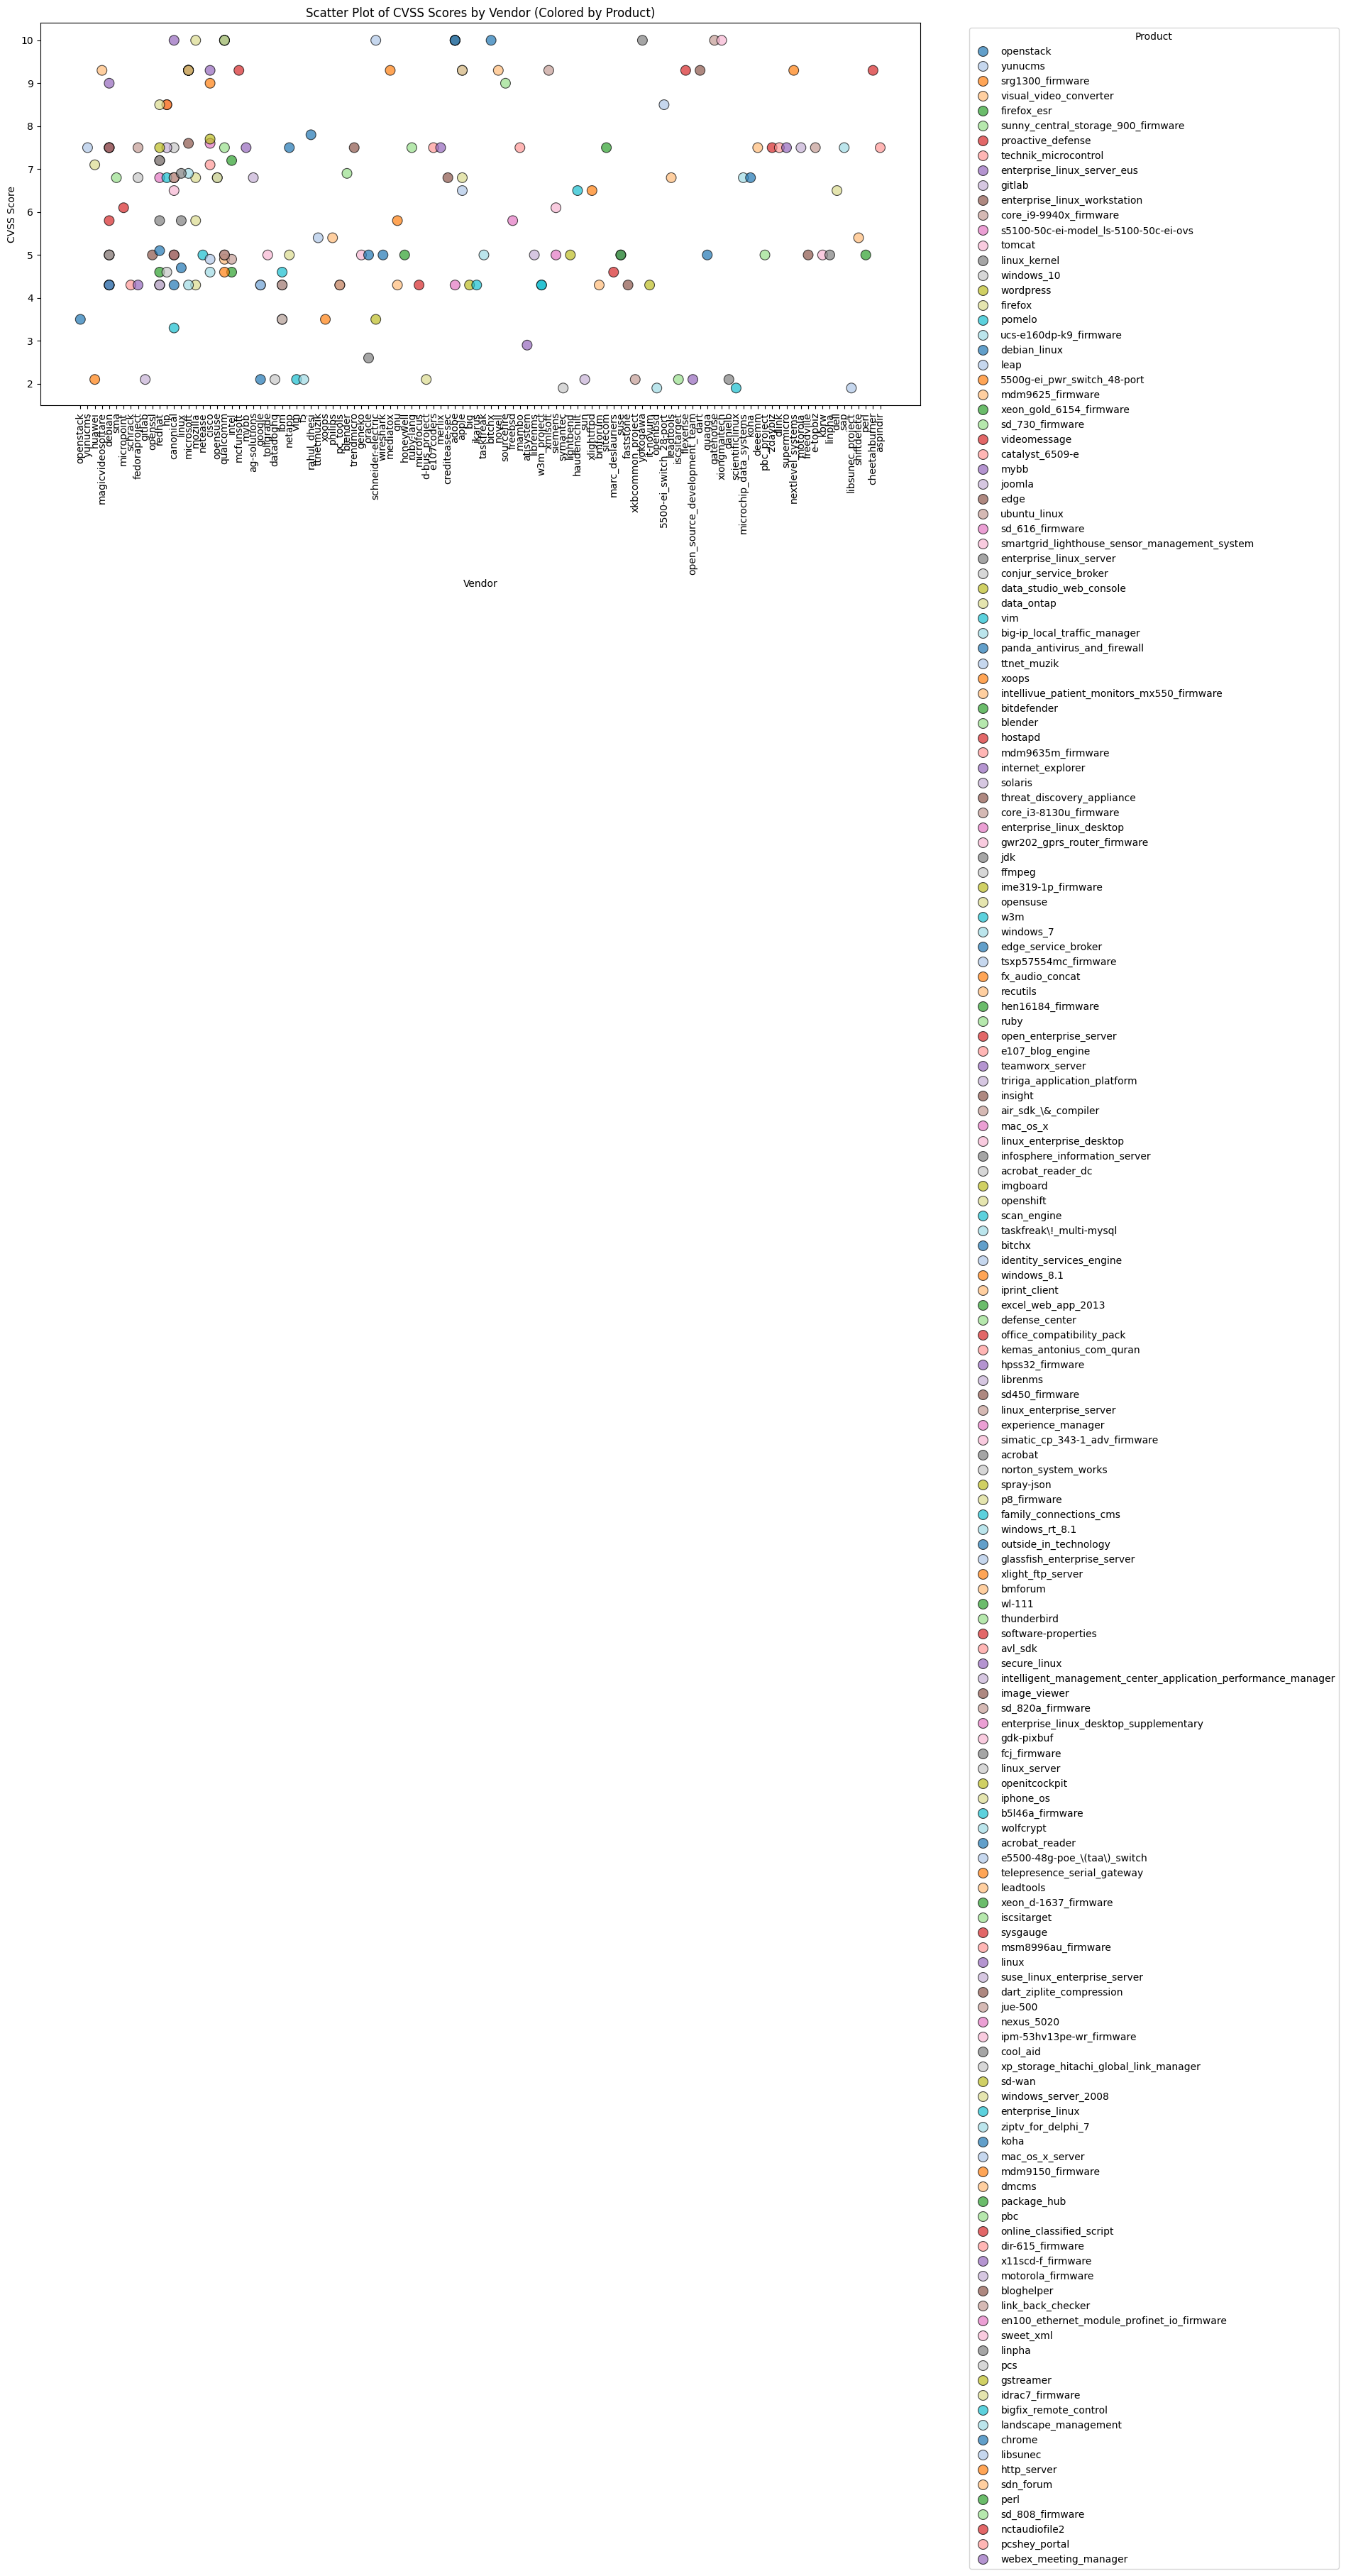

In [38]:
sample = merged_df1[['vendor', 'cvss', 'product']].dropna().sample(n=200, random_state=42)

plt.figure(figsize=(16, 7))
sns.scatterplot(
    data=sample,
    x='vendor',
    y='cvss',
    hue='product',
    palette='tab20',
    s=100,
    edgecolor='k',
    alpha=0.7
)

plt.title('Scatter Plot of CVSS Scores by Vendor (Colored by Product)')
plt.xlabel('Vendor')
plt.ylabel('CVSS Score')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Product')
plt.tight_layout()
plt.show()

In [45]:
vendors
vendors2 =vendors
vendors2.groupby('vendor')['cve_id'].nunique()

,cve_id
vendor,
-,10
.bbsoftware,3
.joomclan,1
.matteoiammarrone,1
1-script,1
...,...
zxid,1
zyxel,75
zzcms,40
